## Spectrum class

### Spectral line class

In [27]:
import pandas as pd
import numpy as np
import shutil
import os

class SpectralLine():

    def __init__(self, data):
        self.line = data
        self.intensity = data['intensity']
        self.energy = data['energy']
        self.length = len(data)

        try:

            self.max_index = data['intensity'].idxmax()
            self.before_max = data.loc[:self.max_index, 'intensity']
            self.after_max = data.loc[self.max_index:, 'intensity']
            self.good_before_max = data.loc[:self.max_index,'intensity'].is_monotonic_increasing
            self.good_after_max = data.loc[self.max_index:, 'intensity'].is_monotonic_decreasing

        except ValueError:
            print("substituting the rest with nans!")
            self.max_index = np.nan
            self.before_max = np.nan
            self.after_max = np.nan
            self.good_before_max = np.nan
            self.good_after_max = np.nan

    def get_first_point(self):
        first_point_energy = self.energy[0]
        first_point_intensity = self.intensity[0]
        return (first_point_energy, first_point_intensity)
    
    def get_point(self, which_point):
        point_intensity = self.intensity.iloc[which_point]
        point_energy = self.energy.iloc[which_point]
        return (point_energy, point_intensity)

In [459]:
test_line_good = pd.DataFrame({
    'energy': [12323.2801, 12323.29516, 12323.31023, 12323.3253, 12323.3262, 12323.34036, 12323.35543, 12323.3705, 12323.38556],
    'intensity': [0.0537, 0.1423, 0.3976, 0.69338, 0.69411, 0.53055, 0.15191, 0.04461, 0.02834]
})

test_spectralline_good = SpectralLine(test_line_good)
# print(test_spectralline_good.line)
# print(test_spectralline_good.intensity)
# print(test_spectralline_good.energy)
# print(test_spectralline_good.length)
print(test_spectralline_good.line)
print(test_spectralline_good.before_max)
print(test_spectralline_good.after_max)
print(test_spectralline_good.max_index)
print(test_spectralline_good.good_before_max)
print(test_spectralline_good.good_after_max)
print(test_spectralline_good.get_point(5))

        energy  intensity
0  12323.28010    0.05370
1  12323.29516    0.14230
2  12323.31023    0.39760
3  12323.32530    0.69338
4  12323.32620    0.69411
5  12323.34036    0.53055
6  12323.35543    0.15191
7  12323.37050    0.04461
8  12323.38556    0.02834
0    0.05370
1    0.14230
2    0.39760
3    0.69338
4    0.69411
Name: intensity, dtype: float64
4    0.69411
5    0.53055
6    0.15191
7    0.04461
8    0.02834
Name: intensity, dtype: float64
4
True
True
(12323.34036, 0.53055)


### Spectrum class

In [28]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

def gauss(x, mu, sigma, c, y):

    return c * 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2 * sigma**2)) + y

class Spectrum():

    def __init__(self, spectrum_path, progressions_path):
        self.spectrum_path = spectrum_path
        self.progressions_path = progressions_path
        self.mean_intensity = self.get_continuum().mean()
        # self.dirty_progressions = self.get_progression_intensities()

    def create_spectrum(self):
        """
        Creates pandas dataframe
        from .dpt file
        """
        spectrum_variables = ['energy', 'intensity']
        spectrum = pd.read_csv(f'{self.spectrum_path}', header=None, names=spectrum_variables, dtype={'energy': 'float64', 'intensity': 'float64'})
        return spectrum

    def get_energy(self):
        """
        gets the energy column (x/0)
        from the spectrum
        """
        spectrum = self.create_spectrum()
        return spectrum['energy']
    
    def get_intensity(self):
        """
        get intensity column (y/1)
        from the spectrum df
        """
        spectrum = self.create_spectrum()
        return spectrum['intensity']

    def get_continuum(self, window=301, polynomial_order=2):
        """
        applies scipy Savitzky-Golay filter
        funtion to get the continuum background
        of the spectrum
        """
        background = sp.signal.savgol_filter(self.get_intensity(), window_length=window, polyorder=polynomial_order)
        return background
    
    def subtract_continuum(self):
        """
        subtracts continuum with
        self.get_continuum and returns
        the resulting spectrum
        """
        x = self.get_energy()
        y = self.get_intensity() - self.get_continuum()
        df = pd.DataFrame({
            'energy': x,
            'intensity': y
        })
        return df
    
    def find_progressions(self):
        """
        finds progressions
        from raw/progressions
        folder and saves them
        in pandas dataframes
        """
        progressions = {}
        for file in os.listdir(self.progressions_path):
            progressions[f'{file}'] = None
            df = pd.read_csv(f'{self.progressions_path}{file}', skiprows=4, names=['index', 'v', 'j_prime', 'v_pprime', 'j_pprime', 'position'], sep='\s+', usecols=['v_pprime', 'j_pprime', 'position'])
            progressions[f'{file}'] = df
        
        return progressions

    def get_positions(self):
        """
        from progressions' information
        (energy, intensity) saves only x-axis position
        information (energy)
        """

        positions = {}
        for name, progression in self.find_progressions().items():
            positions[name] = progression['position']
    
        return positions
    
    def get_v_pprimes(self):
        """
        from progressions' information
        (energy, intensity) saves only v'' info
        """
        
        v_pprimes = {}
        for name, progression in self.find_progressions().items():
            v_pprimes[name] = progression['v_pprime']
    
        return v_pprimes
    
    def get_j_pprimes(self):
        """
        from progressions' information
        (energy, intensity) saves only j'' info
        """
        
        j_pprimes = {}
        for name, progression in self.find_progressions().items():
            j_pprimes[name] = progression['j_pprime']
    
        return j_pprimes
    
    def find_nearest_intensity(self, value):
        """
        finds the nearest experimental spectrum
        point to each of the calculated progressions' position
        """
        s = self.create_spectrum()
        energy = s['energy']
        intensity = s['intensity']
        idx = (np.abs(energy - value)).argmin(skipna=True)
        points_around = 4

        try:

            for shift in range(points_around + 1):
                possible_intensities = intensity[idx-points_around+shift:idx+points_around+1+shift]

                print(f"Checking for max in\n{possible_intensities}")
                max_from_possible = possible_intensities.max()
                not_good = max_from_possible == possible_intensities.iloc[0] or max_from_possible == possible_intensities.iloc[-1]

                if not not_good:
                    break

            idx_max = possible_intensities[possible_intensities == max_from_possible].index[0]
            max_row = s.iloc[idx_max]
            return max_row
        
        except IndexError:

            print("Index out of spectrum, returning nans!")
            return pd.Series({'energy': np.nan, 'intensity': np.nan})
    
    def get_progression_intensities(self):
        """
        by exploiting self.find_nearest_intensity()
        finds all experimental positions
        of calculated progression positions.
        iterates through all progressions in 
        raw/progressions directory.
        if progression is not in the range of spectrum,
        those values are skipped with try/except block.
        """
        progressions = self.get_positions()
        progression_idxs = range(len(progressions.keys())) 
        position_idxs = [range(len(list(progressions.values())[progression_idx])) for progression_idx in progression_idxs]
        found_lines = [[] for i in progression_idxs]
        for progression_idx in progression_idxs:
            print(f'taking progression {progression_idx}...')
            for position_idx in position_idxs[progression_idx]:
                try:
                    print(f'taking position {position_idx} in progression {progression_idx}')
                    found_line = self.find_nearest_intensity(list(progressions.values())[progression_idx][position_idx])
                    print(f'found line is {list(progressions.values())[progression_idx][position_idx]}')
                    print(f"found line literally is:\n{found_line}\n")
                    found_lines[progression_idx].append(found_line.to_frame().T)
                except IndexError:
                    print('progression out of spectrum, skipping to next iteration')
                    found_lines[progression_idx].append(pd.DataFrame({'energy': np.nan, 'intensity': np.nan}))

        final_format = {key: value for key, value in progressions.items()}
        for progression_idx in range(len(list(progressions.keys()))):
            pandas_progression = pd.concat(found_lines[progression_idx])
            final_format[list(progressions.keys())[progression_idx]] = pandas_progression
        return final_format
    
    def find_good_lines(self, found_lines):
        """
        from found progressions,
        extracts only the lines which could undergo
        gaussian approximation.
        takes few points around determined maximum value and
        fits those to gaussian function. Then returns position
        for each good line, according to gaussian fit.
        """
        found_lines_keys = list(found_lines.keys())
        points_around = 4
        energy = self.get_energy()
        continuum = pd.DataFrame({
            'energy': energy,
            'intensity': self.get_continuum()
        })
        spectrum = self.create_spectrum()
        progressions = list(found_lines.values())
        progression_idxs = range(len(progressions))
        position_idxs = [range(len(progressions[progression_idx])) for progression_idx in progression_idxs]
        clean_lines = {key: [] for key, value in found_lines.items()}

        for progression_idx in progression_idxs:

            print(f'taking progression {progression_idx}')

            for position_idx in position_idxs[progression_idx]:

                if position_idx == 0:
                    previous_full_point = progressions[progression_idx].iloc[position_idx + 2]
                    previous_point_name = progressions[progression_idx].iloc[position_idx-1].name

                else:
                    previous_full_point = progressions[progression_idx].iloc[position_idx-1]
                    previous_point_name = progressions[progression_idx].iloc[position_idx-1].name

                full_point = progressions[progression_idx].iloc[position_idx]
                point_name = progressions[progression_idx].iloc[position_idx].name

                if position_idx == len(position_idxs[progression_idx])-1:
                    next_full_point = progressions[progression_idx].iloc[position_idx-2]
                else:
                    next_point_name = progressions[progression_idx].iloc[position_idx+1].name

                print(f'got point {point_name} with energy {full_point}')
                continuum_around_point = continuum.iloc[point_name-100:point_name+100]['intensity'].mean()
                print(f"continuum level around point:\n{continuum_around_point}\n")
                possible_line = spectrum.iloc[point_name-points_around:point_name+points_around+1]
                possible_line_previous = spectrum.iloc[previous_point_name-points_around:previous_point_name+points_around+1]
                possible_line_next = spectrum.iloc[next_point_name-points_around:next_point_name+points_around+1]
                
                print("---------------------- 1st try ---------------------")
                line_to_check = SpectralLine(possible_line)
                line_to_check_previous = SpectralLine(possible_line_previous)
                line_to_check_next = SpectralLine(possible_line_next)
                print(f'possible line is:\n{line_to_check.line}')
                print(f'max intensity is at point:\n{line_to_check.max_index}')
                print(f'part of the line before the max index:\n{line_to_check.before_max}')
                print(f'part of the line after the max index:\n{line_to_check.after_max}')
                print(line_to_check.good_before_max)
                print(line_to_check.good_after_max)
                possible_line_is_good = line_to_check.good_before_max and line_to_check.good_after_max
                print(possible_line_is_good)

                print("----------continuum and anomaly check---------------")
                current_point_intensity = line_to_check.intensity.max()
                previous_point_intensity = line_to_check_previous.intensity.max()
                next_point_intensity = line_to_check_next.intensity.max()
                line_group = [current_point_intensity, previous_point_intensity, next_point_intensity]
                line_group_mean = np.array(line_group).mean()
                print(f"line group mean intensity: {line_group_mean}")
                is_not_in_noise = current_point_intensity > continuum_around_point*1.9
                is_not_anomalous = current_point_intensity < line_group_mean*2
                print(f"line is strong enough: {is_not_in_noise}")
                print(f"line is not anomalous: {is_not_anomalous}")
                if (possible_line_is_good and is_not_anomalous) and is_not_in_noise:
                    print('possible line is good')
                    clean_lines[found_lines_keys[progression_idx]].append(line_to_check.line)
                else:
                    print("================================== 2nd try ==============================")
                    print("Trying with shortening the line from both sides")
                    another_line = SpectralLine(spectrum.iloc[point_name - (points_around-1):point_name + (points_around)])
                    another_line_previous = SpectralLine(spectrum.iloc[previous_point_name - (points_around-1):previous_point_name + (points_around)])
                    another_line_next = SpectralLine(spectrum.iloc[next_point_name - (points_around-1):next_point_name + (points_around)])
                    print(f'possible line is:\n{another_line.line}')
                    print(f'max intensity is at point:\n{another_line.max_index}')
                    print(f'part of the line before the max index:\n{another_line.before_max}')
                    # print(type(line_to_check.before_max))
                    print(f'part of the line after the max index:\n{another_line.after_max}')
                    # print(type(another_line.after_max))
                    print(another_line.good_before_max)
                    print(another_line.good_after_max)
                    print("----------continuum and anomaly check---------------")
                    current_another_point_intensity = another_line.intensity.max()
                    previous_another_point_intensity = another_line_previous.intensity.max()
                    next_another_point_intensity = another_line_next.intensity.max()
                    another_line_group = [previous_another_point_intensity, current_another_point_intensity, next_another_point_intensity]
                    another_line_group_mean = np.array(another_line_group).mean()
                    another_line_is_good = another_line.good_before_max and another_line.good_after_max
                    another_line_is_not_anomalous = current_another_point_intensity < another_line_group_mean*1.9
                    print(another_line_is_good and another_line_is_not_anomalous)
                    if (another_line_is_good and another_line_is_not_anomalous) and is_not_in_noise:
                        clean_lines[found_lines_keys[progression_idx]].append(another_line.line)
                    else:
                        print('line was bad after all... :(')
                        clean_lines[found_lines_keys[progression_idx]].append(np.nan)
        
        return clean_lines
    

    def optimize_positions(self, lines, func=gauss):
        
        lines_keys = list(lines.keys())
        progression_idxs = range(len(lines_keys))

        energy = self.get_energy()
        continuum = pd.DataFrame({
            'energy': energy,
            'intensity': self.get_continuum()
        })

        best_positions = {key: [] for key, _ in lines.items()}
        condition_numbers = {key: [] for key, _ in lines.items()}

        for progression_idx in progression_idxs:
            print(f"optimizing progression #{progression_idx}")
            progression_idx_key = lines_keys[progression_idx]
            position_idxs = range(len(lines[progression_idx_key]))
            for position_idx in position_idxs:
                try:
                    print(f"optimizing position {position_idx}")
                    current_line = lines[progression_idx_key][position_idx]

                    xs = current_line['energy']
                    xs_linspace = np.linspace(xs.min(), xs.max(), 100)
                    ys = current_line['intensity']
                    print(f"x-values: {xs}")
                    print(f"w/ type {type(xs)}")
                    print(f"w/ length {len(xs)}")
                    print(f"y-values: {ys}")
                    print(f"w/ type {type(ys)}")
                    print(f"w/ length {len(ys)}")
                    initial_mu = xs_linspace.mean()
                    initial_sigma = 0.02
                    initial_c = 0
                    initial_y = 0.004
                    initial_guess = [initial_mu, initial_sigma, initial_c, initial_y]

                    popt, pcov = sp.optimize.curve_fit(func, xs, ys, p0=initial_guess, maxfev=1000000)
                    calculated_mu = popt[0]
                    condition_number = np.linalg.cond(pcov) # if this is too big, might be a problem
                    
                    best_positions[progression_idx_key].append(calculated_mu)
                    condition_numbers[progression_idx_key].append(condition_number)
                except TypeError:
                    print("Encountered nan type, not performing optimiziation on empty value")
                    best_positions[progression_idx_key].append(np.nan)
                    condition_numbers[progression_idx_key].append(np.nan)
                # left here. check the order of lines and if there are any lines dropped 26.09.2024.
        
        return best_positions, condition_numbers
        
    
    def add_calculated_to_progression_file(self, progressions, results):

        # progressions_keys = list(progressions.keys())
        # results_positions = results[0]
        # results_test = results[1]
        # final_return = {key: None for key, _ in progressions.items()}
        
        # for key_idx in range(len(progressions_keys)):
        #     to_modify = progressions[progressions_keys[key_idx]]
        #     print(f"What i want to modify: {to_modify}")
        #     print(f"type of what i want to modify: {type(to_modify)}")
        #     to_modify['gaus'] = results_positions[progressions_keys[key_idx]]
        #     to_modify['condition_number'] = results_test[progressions_keys[key_idx]]
        #     final_return[progressions_keys[key_idx]] = to_modify
        
        # return final_return
        pass


        

        



    




<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:77: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Aigars\AppData\Local\Temp\ipykernel_18020\1194505180.py:77: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(f'{self.progressions_path}{file}', skiprows=4, names=['index', 'v', 'j_prime', 'v_pprime', 'j_pprime', 'position'], sep='\s+', usecols=['v_pprime', 'j_pprime', 'position'])


### Tests for Spectrum class methods

In [110]:
spectrum_path = 'raw/ajkr23_31/ajkr23_31m.dpt'
progressions_path = 'raw/ajkr23_31/progressions/'
ajkr23_31 = Spectrum(spectrum_path=spectrum_path, progressions_path=progressions_path)
# 11887.0344
ajkr23_31_nearest = ajkr23_31.find_nearest_intensity(np.nan)
print(ajkr23_31_nearest)
print(type(ajkr23_31_nearest))

Checking for max in
Series([], Name: intensity, dtype: float64)
Index out of spectrum, returning nans!
energy      NaN
intensity   NaN
dtype: float64
<class 'pandas.core.series.Series'>


C:\Users\Aigars\AppData\Local\Temp\ipykernel_13728\3999011164.py:127: FutureWarning: The behavior of Series.argmax/argmin with skipna=False and NAs, or with all-NAs is deprecated. In a future version this will raise ValueError.
  idx = (np.abs(energy - value)).argmin(skipna=True)


### Test for the most of all methods

In [7]:
spectrum_path = 'raw/ajkr23_31/ajkr23_31m.dpt'
progressions_path = 'raw/ajkr23_31/progressions/'
ajkr23_31 = Spectrum(spectrum_path=spectrum_path, progressions_path=progressions_path)

ajkr23_31_energy = ajkr23_31.get_energy()
ajkr23_31_intensity = ajkr23_31.get_intensity()
ajkr23_31_spectrum = ajkr23_31.create_spectrum()
ajkr23_31_continuum = ajkr23_31.get_continuum()
ajkr23_31_progressions = ajkr23_31.find_progressions()
ajkr23_31_positions = ajkr23_31.get_positions()
ajkr23_31_nearest = ajkr23_31.find_nearest_intensity(11887.0344)
ajkr23_31_found_lines = ajkr23_31.get_progression_intensities()
ajkr23_31_subtracted = ajkr23_31.subtract_continuum()
ajkr23_31_j_pprimes = ajkr23_31.get_j_pprimes()
ajkr23_31_v_pprimes = ajkr23_31.get_v_pprimes()


print(ajkr23_31_spectrum)
print(ajkr23_31_energy)
print(ajkr23_31_intensity)
print(f"continuum: {ajkr23_31_continuum}")
print(f"continuum: {type(ajkr23_31_continuum)}")
print(ajkr23_31_progressions)
print(ajkr23_31_positions)
print(f"max row: {ajkr23_31_nearest}")
print(ajkr23_31.mean_intensity)
print(ajkr23_31_found_lines)
print(ajkr23_31_j_pprimes)
print(ajkr23_31_v_pprimes)
print(len(ajkr23_31_positions))


Checking for max in
213663    0.01257
213664    0.00645
213665    0.00184
213666    0.00255
213667    0.00425
213668    0.00441
213669    0.00408
213670    0.00196
213671    0.00059
Name: intensity, dtype: float64
Checking for max in
213664    0.00645
213665    0.00184
213666    0.00255
213667    0.00425
213668    0.00441
213669    0.00408
213670    0.00196
213671    0.00059
213672    0.00036
Name: intensity, dtype: float64
Checking for max in
213665    0.00184
213666    0.00255
213667    0.00425
213668    0.00441
213669    0.00408
213670    0.00196
213671    0.00059
213672    0.00036
213673    0.00011
Name: intensity, dtype: float64
taking progression 0...
taking position 0 in progression 0
Checking for max in
247725    0.00039
247726    0.00063
247727    0.00095
247728    0.00115
247729    0.00115
247730    0.00090
247731    0.00057
247732    0.00036
247733    0.00026
Name: intensity, dtype: float64
found line is 12348.458523
found line literally is:
energy       12348.45566
intensit

### getting the clean lines

In [4]:
spectrum_path = 'raw/ajkr23_31/ajkr23_31m.dpt'
progressions_path = 'raw/ajkr23_31/progressions/'
ajkr23_31 = Spectrum(spectrum_path=spectrum_path, progressions_path=progressions_path)
ajkr23_31_found_lines = ajkr23_31.get_progression_intensities()
ajkr23_31_clean_lines = ajkr23_31.find_good_lines(ajkr23_31_found_lines)
ajkr23_31_clean_lines

taking progression 0...
taking position 0 in progression 0
Checking for max in
247725    0.00039
247726    0.00063
247727    0.00095
247728    0.00115
247729    0.00115
247730    0.00090
247731    0.00057
247732    0.00036
247733    0.00026
Name: intensity, dtype: float64
found line is 12348.458523
found line literally is:
energy       12348.45566
intensity        0.00115
Name: 247728, dtype: float64

taking position 1 in progression 0
Checking for max in
245877    0.39760
245878    0.69338
245879    0.69411
245880    0.53055
245881    0.15191
245882    0.04461
245883    0.02834
245884    0.00589
245885    0.00698
Name: intensity, dtype: float64
found line is 12323.351728
found line literally is:
energy       12323.32620
intensity        0.69411
Name: 245879, dtype: float64

taking position 2 in progression 0
Checking for max in
241193    0.00115
241194    0.00165
241195    0.00282
241196    0.00406
241197    0.00416
241198    0.00345
241199    0.00126
241200    0.00011
241201    0.000

{'fin_tran116.out': [             energy  intensity
  247724  12348.39540    0.00009
  247725  12348.41046    0.00039
  247726  12348.42553    0.00063
  247727  12348.44060    0.00095
  247728  12348.45566    0.00115
  247729  12348.45596    0.00115
  247730  12348.47073    0.00090
  247731  12348.48579    0.00057
  247732  12348.50086    0.00036,
  nan,
               energy  intensity
  241194  12259.65568    0.00165
  241195  12259.67075    0.00282
  241196  12259.68581    0.00406
  241197  12259.69018    0.00416
  241198  12259.70088    0.00345
  241199  12259.71594    0.00126
  241200  12259.73101    0.00011,
               energy  intensity
  239358  12234.64584    0.00090
  239359  12234.66091    0.00182
  239360  12234.67598    0.00322
  239361  12234.69104    0.00407
  239362  12234.70611    0.00258
  239363  12234.72117    0.00053
  239364  12234.73624    0.00000,
               energy  intensity
  234699  12171.57887    0.00261
  234700  12171.59394    0.00604
  234701  1217

### gaus fit test

In [5]:
optimized_test = ajkr23_31.optimize_positions(ajkr23_31_clean_lines)
print(optimized_test)

optimizing progression #0
optimizing position 0
x-values: 247724    12348.39540
247725    12348.41046
247726    12348.42553
247727    12348.44060
247728    12348.45566
247729    12348.45596
247730    12348.47073
247731    12348.48579
247732    12348.50086
Name: energy, dtype: float64
w/ type <class 'pandas.core.series.Series'>
w/ length 9
y-values: 247724    0.00009
247725    0.00039
247726    0.00063
247727    0.00095
247728    0.00115
247729    0.00115
247730    0.00090
247731    0.00057
247732    0.00036
Name: intensity, dtype: float64
w/ type <class 'pandas.core.series.Series'>
w/ length 9
optimizing position 1
Encountered nan type, not performing optimiziation on empty value
optimizing position 2
x-values: 241194    12259.65568
241195    12259.67075
241196    12259.68581
241197    12259.69018
241198    12259.70088
241199    12259.71594
241200    12259.73101
Name: energy, dtype: float64
w/ type <class 'pandas.core.series.Series'>
w/ length 7
y-values: 241194    0.00165
241195    0.

[115 117]
[117 115]


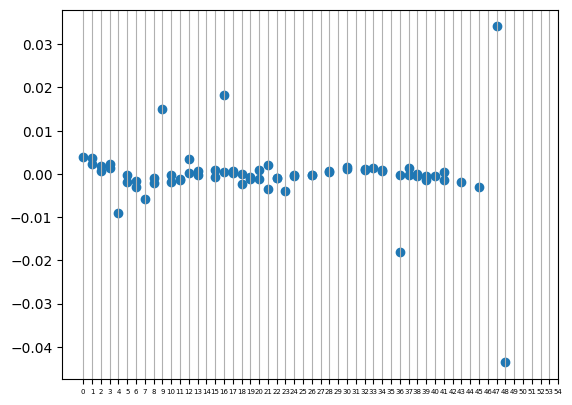

[67 69]
[69 67]


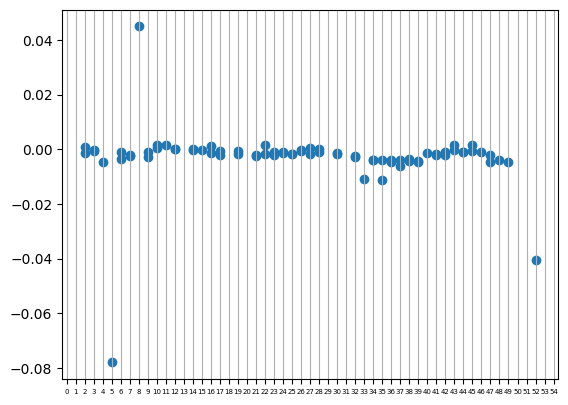

[68 70]
[70 68]


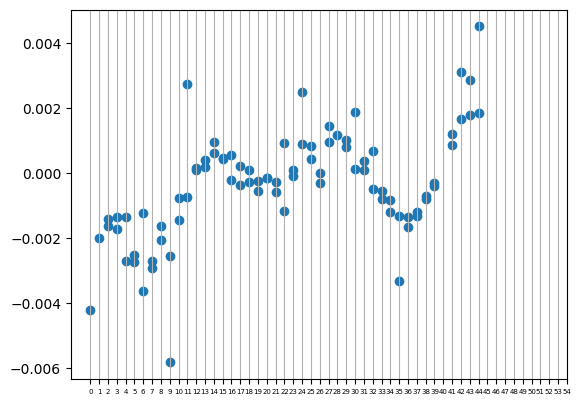

{'fin_tran116.out':      v_pprime  j_pprime      position          gaus  condition_number  \
 0           0       115  12348.458523  12348.454639      2.539426e+06   
 1           0       117  12323.351728           NaN               NaN   
 2           1       115  12259.688584  12259.686354      2.194843e+05   
 3           1       117  12234.689885  12234.686167      8.634830e+04   
 4           2       115  12171.610746  12171.608860      2.459844e+04   
 ..        ...       ...           ...           ...               ...   
 157        78       117   8891.396185           NaN               NaN   
 158        79       115   8936.661185           NaN               NaN   
 159        79       117   8965.963118           NaN               NaN   
 160        80       115   9015.939909           NaN               NaN   
 161        80       117   9051.693554           NaN               NaN   
 
      delta expt-gaus pr  
 0           0.003884  r  
 1                NaN  p  
 2        

<Figure size 640x480 with 0 Axes>

In [26]:
def save_to_fin(progressions, results, path="fin/"):

    progressions_keys = list(progressions.keys())
    to_return = {}
    for key in progressions_keys:
        new_df = progressions[key]
        new_df['gaus'] = results[0][key]
        new_df['condition_number'] = results[1][key]
        new_df['delta expt-gaus'] = new_df['position'] - new_df['gaus']
        j_pprimes = new_df['j_pprime'].unique()
        print(j_pprimes)
        j_pprimes_sorted = np.sort(j_pprimes)[::-1]
        print(j_pprimes_sorted)
        new_df['pr'] =  np.where(new_df['j_pprime'] == j_pprimes_sorted[0], 'p', 'r')
        to_return[key] = new_df
        plt.scatter(x=new_df['v_pprime'], y=new_df['delta expt-gaus'])
        plt.xticks(np.arange(int(min(new_df['v_pprime'])), 55, 1), fontsize=5)
        plt.grid(axis='x')
        plt.show()
        plt.clf()
        if os.path.exists(f"{path}{key}"):
            shutil.rmtree(f"{path}{key}")
        os.mkdir(f"{path}{key}")
        new_df.to_csv(f"{path}{key}/full_{key}") # saving the full progressions

        # only ps
        new_df_p = new_df[new_df.pr == 'p']
        new_df_p.to_csv(f"{path}{key}/p_{key}")

        # only rs
        new_df_p = new_df[new_df.pr == 'r']
        new_df_p.to_csv(f"{path}{key}/r_{key}")

    return to_return

save_to_fin(ajkr23_31_progressions, optimized_test)

### Whiteboard


In [305]:
testering = ajkr23_31_spectrum.iloc[500-4:500+4]
testering_max_int = testering[testering['intensity'] == testering['intensity'].max()]
print(testering)
print(testering_max_int)

         energy  intensity
496  9001.50688    0.00006
497  9001.52195    0.00042
498  9001.53701    0.00046
499  9001.54575    0.00048
500  9001.55208    0.00047
501  9001.56715    0.00034
502  9001.58221    0.00019
503  9001.59728    0.00021
         energy  intensity
499  9001.54575    0.00048


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


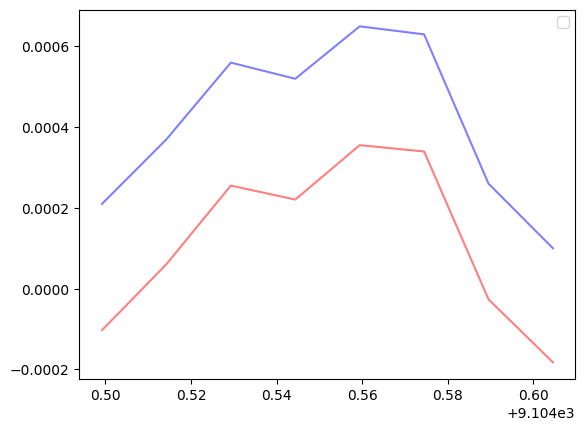

In [260]:
plt.plot(ajkr23_31_subtracted.iloc[8113-4:8113+4]['energy'], ajkr23_31_subtracted.iloc[8113-4:8113+4]['intensity'], color='red', alpha=0.5)
plt.plot(ajkr23_31_spectrum.iloc[8113-4:8113+4]['energy'], ajkr23_31_spectrum.iloc[8113-4:8113+4]['intensity'], color='blue', alpha=0.5)
plt.legend()
plt.show()

## curve fit example

Fitted mu: 4.146544961493995
Fitted sigma: 1.1637885421786314
Fitted c (amplitude): 12.106459907871288
Fitted y (vertical offset): 0.6252193215409141


<module 'matplotlib.pyplot' from 'c:\\Users\\Aigars\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\matplotlib\\pyplot.py'>

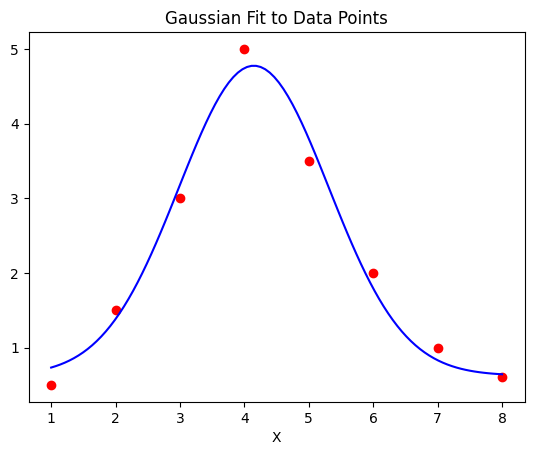

In [468]:
import numpy as np

def gauss(x, mu, sigma, c, y):

    return c * 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2 / (2 * sigma**2)) + y

# Example data points (replace with your real data)
x_data = np.array([1, 2, 3, 4, 5, 6, 7, 8])
y_data = np.array([0.5, 1.5, 3.0, 5.0, 3.5, 2.0, 1.0, 0.6])

# Define the Gaussian function with offset
def gauss(x, mu, sigma, c, y):
    return c * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2)) + y

# Initial guess for the parameters: mu, sigma, c, y
initial_guess = [4, 1, 5, 0.5]  # Adjust these based on your data

# Perform the curve fitting
params, covariance = sp.optimize.curve_fit(gauss, x_data, y_data, p0=initial_guess)

# Extract the fitted parameters
mu_fit, sigma_fit, c_fit, y_fit = params

# Print the results
print(f"Fitted mu: {mu_fit}")
print(f"Fitted sigma: {sigma_fit}")
print(f"Fitted c (amplitude): {c_fit}")
print(f"Fitted y (vertical offset): {y_fit}")

# Generate fitted Gaussian curve
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = gauss(x_fit, mu_fit, sigma_fit, c_fit, y_fit)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Data', color='red')
plt.plot(x_fit, y_fit, label='Fitted Gaussian', color='blue')
plt.title('Gaussian Fit to Data Points')
plt.xlabel('X')
plt


## Getting spectrum data

In [3]:
spectra = []
spectrum_variables = ['energy', 'intensity']
spectrum = ajkr23_31.create_spectrum()
get_energy = lambda x: x['energy']
get_intensity = lambda x: x['intensity']
mean_intensity = get_intensity(spectrum).mean()

# print(spectrum.iloc[:,1])
print(spectrum[0:50])
print(spectrum.iloc[0][0])
print(spectrum.iloc[0][1])
print(len(spectrum))
print(len(spectrum[:1]))
print(f"Mean intensity of the spectrum: {mean_intensity}")

        energy  intensity
0   6999.99686   -0.00005
1   7000.01192   -0.00005
2   7000.02699    0.00017
3   7000.04206    0.00023
4   7000.05712    0.00008
5   7000.07219    0.00017
6   7000.08725    0.00032
7   7000.10232    0.00017
8   7000.11739   -0.00007
9   7000.13245   -0.00017
10  7000.14752   -0.00013
11  7000.16259   -0.00017
12  7000.17765   -0.00023
13  7000.19272   -0.00016
14  7000.20778   -0.00013
15  7000.22285   -0.00010
16  7000.23792   -0.00003
17  7000.25298    0.00004
18  7000.26805    0.00014
19  7000.28311    0.00008
20  7000.29818   -0.00006
21  7000.31325   -0.00002
22  7000.32831    0.00011
23  7000.34338    0.00013
24  7000.35845   -0.00004
25  7000.37351   -0.00023
26  7000.38858   -0.00019
27  7000.40364    0.00005
28  7000.41871    0.00025
29  7000.43378    0.00024
30  7000.44884    0.00012
31  7000.46391    0.00023
32  7000.47897    0.00030
33  7000.49404   -0.00001
34  7000.50911   -0.00019
35  7000.52417   -0.00004
36  7000.53924    0.00013
37  7000.554

C:\Users\Aigars\AppData\Local\Temp\ipykernel_5952\3097259726.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(spectrum.iloc[0][0])
C:\Users\Aigars\AppData\Local\Temp\ipykernel_5952\3097259726.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(spectrum.iloc[0][1])


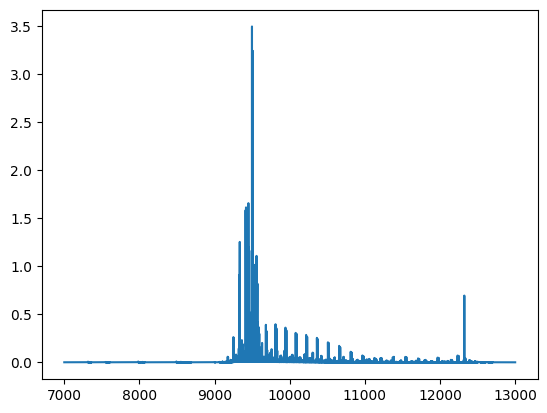

In [4]:
plt.plot(spectrum['energy'], spectrum['intensity'])
# plt.axis([9500, 11000, 0, 0.01])
plt.show()

## Creating the moving average

$w$ - window size for how smooth the MA will be


$MA = \frac{\sum_{{i=n-w}}^n i}{w}$

In [5]:
def get_window(data, current_point, width=100):
    """
    consecutively takes number of points defined in width argument

    """

    if current_point <= width-1:
        return data[:current_point+1]
    else:
        return data[current_point-width:current_point]


def moving_average(data, width=100):
    """
    Gets the average of defined window.
    Arguments: data = (line chart with x, y values)
               width = defining the window of averaging
    

    current average at point is the simple average of the previous 50 points
    including the current one
    """

    y_avg = []
    for idx, row in data.iterrows():
        window = get_window(data, idx, width)
        # print(f"Got window...{idx+1}")
        sum_window = window.iloc[:, 1].sum()
        # print(f"Sum of the window: {sum_window}")
        # print(f"Length of the window: {len(window)}")
        avg_window = sum_window / len(window)
        # print(f"avg of window: {avg_window}")
        y_avg.append(avg_window)
    
    return y_avg

        


mv_avg = moving_average(spectrum, 100)


In [6]:
len(mv_avg)

398243

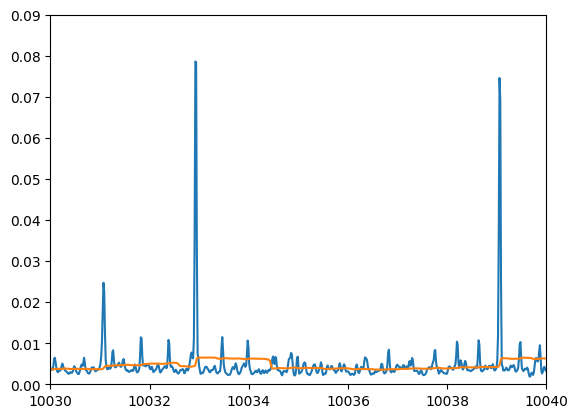

In [7]:
plt.plot(spectrum['energy'], spectrum['intensity'])
plt.plot(spectrum['energy'], mv_avg)
plt.axis([10030, 10040, 0.00, 0.09])
plt.show()

In [8]:
pd.DataFrame(mv_avg).to_csv('fin/mv_avg.csv', index=False)

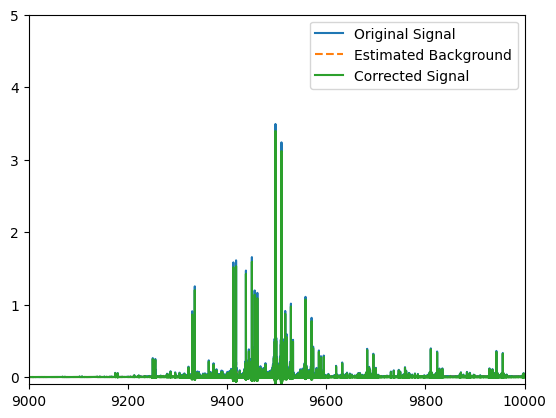

In [16]:
# Sample Data: Replace with actual spectroscopy data
x = get_energy(spectrum)
y = get_intensity(spectrum)

# Polynomial Fitting (Example with Savitzky-Golay filter for background)
background = sp.signal.savgol_filter(y, window_length=301, polyorder=2)  # Adjust window length and order as needed
corrected_signal = y - background

plt.plot(x, y, label='Original Signal')
plt.plot(x, background, label='Estimated Background', linestyle='--')
plt.plot(x, corrected_signal, label='Corrected Signal')
plt.legend()
# plt.axis([9600, 9625, -0.001, 0.006])
# plt.axis([9630, 9640, -0.001, 0.006])
plt.axis([9000, 10000, -0.1, 5])
plt.show()



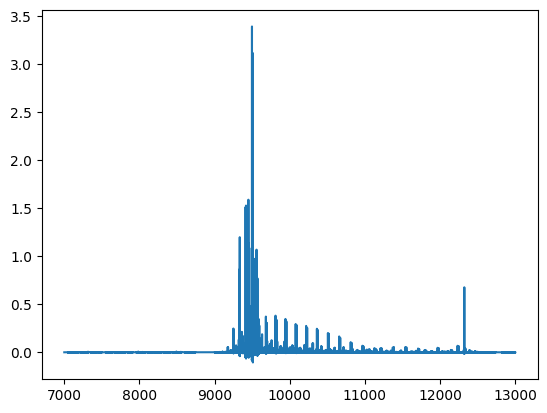

In [18]:
corrected_spectrum = pd.DataFrame({
    "energy": get_energy(spectrum),
    "intensity": corrected_signal
})
plt.plot(corrected_spectrum['energy'], corrected_spectrum['intensity'])
plt.show()


In [20]:
corrected_spectrum.to_csv('raw/ajkr23_31/ajkr23_31c.dpt', index=False, header=False, sep=',')

## Old intensity finder function

In [29]:
from os import system
import time

def int_expt(p="progression.txt", s="spectr.txt", n=""): # wrapping the program in a single reusable function
    start = time.monotonic() # * start timer
    print("working...")
    border = [n/10000 for n in range(0, 1200, 1)] # range in which lines are taken for a test #! do not change
    print("steps until: {}".format(border[-1]))
    energies_p = [] # for storing progression line positions and vibrational quantum numbers for lower level
    energies_intensities_s = [] # for storing the whole spectrum (energies + intensities for each point)
    intensities_p = [] # final intensities for a progression of interest


    with open(p, "rt") as p: # opening a progression data and storing inside a list
        lines = p.readlines()
        for line_idx in range(len(lines)):
            if line_idx < 4:
                continue
            else:
                splitted = lines[line_idx].split()
                energies_p.append([int(splitted[0]), float(splitted[1])])

    all_possible = [[] for i in range(len(energies_p))]

    with open(s, "rt") as s: # opening the data of whole spectrum and storing inside a list
        lines = s.readlines()
        for line in lines:
            splitted = line.split(',')
            energies_intensities_s.append([float(splitted[0]), float(splitted[1])])
            


    for idx_p in range(len(energies_p)): # iterating through progression indices
        for n in border: # iterating through range of interest around each possible line
            possibility = energies_p[idx_p][1] - .0600 + n # saving a possible position for max intensity for a single line
            for idx_s in range(len(energies_intensities_s)): # iterating through indices of all the spectrum data
                if possibility == energies_intensities_s[idx_s][0]: # finding intensity at theoretical position
                    for idx_ss in range(idx_s - 5, idx_s + 5, 1): # iterating for a sacond time, now in closer range #! do not change
                        all_possible[idx_p].append(energies_intensities_s[idx_ss][1]) # append all the possible intensities around calc line

    #just finding max intensity of lines around calc
    for possibilities in all_possible:
        if possibilities:
            intensities_p.append(max(possibilities))
            print(max(possibilities))

    # saving intensities of a progression in a file
    with open("intensities{}.dat".format(n), "wt") as ints:
        for i in range(len(intensities_p)):
            ints.write("{}\t{}\n".format(energies_p[i][0], intensities_p[i]))

    print("Done!")
    end = time.monotonic() # * end timer
    print("Finding intensities took {} minutes".format((int(end-start))/60))

#running a function
# int_expt()

In [27]:
progressions = ['fin_tran68.out', 'fin_tran69.out', 'fin_tran116.out']
for progression in progressions:
    int_expt(p="raw/ajkr23_31/progressions/{}".format(progression), s="raw/ajkr23_31/ajkr23_31c.dpt", n=f"_{progression}")

working...
steps until: 0.1199
Done!
Finding intensities took 75.71666666666667 minutes
working...
steps until: 0.1199
Done!
Finding intensities took 85.05 minutes
working...
steps until: 0.1199
Done!
Finding intensities took 88.86666666666666 minutes


In [57]:
progressions = find_progressions(directory)
positions = get_positions(progressions)
print(progressions)
print(positions)

[     v_pprime  j_pprime      position
0           0       115  12348.458523
1           0       117  12323.351728
2           1       115  12259.688584
3           1       117  12234.689885
4           2       115  12171.610746
..        ...       ...           ...
157        78       117   8891.396185
158        79       115   8936.661185
159        79       117   8965.963118
160        80       115   9015.939909
161        80       117   9051.693554

[162 rows x 3 columns],      v_pprime  j_pprime      position
0           0        67  12682.300803
1           0        69  12667.146804
2           1        67  12591.545784
3           1        69  12576.452203
4           2        67  12501.458280
..        ...       ...           ...
157        78        69   8519.588190
158        79        67   8525.964083
159        79        69   8527.642493
160        80        67   8534.501850
161        80        69   8537.233909

[162 rows x 3 columns],      v_pprime  j_pprime      position

C:\Users\Aigars\AppData\Local\Temp\ipykernel_5952\347437357.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'{path}{file}', skiprows=4, names=['index', 'v', 'j_prime', 'v_pprime', 'j_pprime', 'position'], delim_whitespace=True,usecols=['v_pprime', 'j_pprime', 'position'])
C:\Users\Aigars\AppData\Local\Temp\ipykernel_5952\347437357.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'{path}{file}', skiprows=4, names=['index', 'v', 'j_prime', 'v_pprime', 'j_pprime', 'position'], delim_whitespace=True,usecols=['v_pprime', 'j_pprime', 'position'])
C:\Users\Aigars\AppData\Local\Temp\ipykernel_5952\347437357.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df =

In [62]:
peaks = sp.signal.find_peaks(corrected_spectrum['intensity'], distance=1)
print(peaks)
# plt.plot(corrected_spectrum['energy'], corrected_spectrum['intensity'])
# plt.scatter(corrected_spectrum['energy'], peaks)
# plt.show()

(array([     3,      6,     10, ..., 398225, 398232, 398240], dtype=int64), {})
